In [210]:
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

import warnings 
warnings.filterwarnings('ignore') 

In [211]:
# SOM for dimensionality reduction

import numpy as np

class SOM():
    """
    The 2-D, rectangular grid self-organizing map class using Numpy.
    """
    def __init__(self, m=3, n=3, dim=3, lr=1, sigma=1, max_iter=3000):
        """
        Parameters
        ----------
        m : int, default=3
            The shape along dimension 0 (vertical) of the SOM.
        n : int, default=3
            The shape along dimesnion 1 (horizontal) of the SOM.
        dim : int, default=3
            The dimensionality (number of features) of the input space.
        lr : float, default=1
            The initial step size for updating the SOM weights.
        sigma : float, optional
            Optional parameter for magnitude of change to each weight. Does not
            update over training (as does learning rate). Higher values mean
            more aggressive updates to weights.
        max_iter : int, optional
            Optional parameter to stop training if you reach this many
            interation.
        """
        # Initialize descriptive features of SOM
        self.m = m
        self.n = n
        self.dim = dim
        self.shape = (m, n)
        self.initial_lr = lr
        self.lr = lr
        self.sigma = sigma
        self.max_iter = max_iter

        # Initialize weights
        self.weights = np.random.normal(size=(m * n, dim))
        self._locations = self._get_locations(m, n)

        # Set after fitting
        self._inertia = None
        self._n_iter_ = None
        self._trained = False

    def _get_locations(self, m, n):
        """
        Return the indices of an m by n array.
        """
        return np.argwhere(np.ones(shape=(m, n))).astype(np.int64)

    def _find_bmu(self, x):
        """
        Find the index of the best matching unit for the input vector x.
        """
        # Stack x to have one row per weight
        x_stack = np.stack([x]*(self.m*self.n), axis=0)
        # Calculate distance between x and each weight
        distance = np.linalg.norm(x_stack - self.weights, axis=1)
        # Find index of best matching unit
        return np.argmin(distance)

    def step(self, x):
        """
        Do one step of training on the given input vector.
        """
        # Stack x to have one row per weight
        x_stack = np.stack([x]*(self.m*self.n), axis=0)

        # Get index of best matching unit
        bmu_index = self._find_bmu(x)

        # Find location of best matching unit
        bmu_location = self._locations[bmu_index,:]

        # Find square distance from each weight to the BMU
        stacked_bmu = np.stack([bmu_location]*(self.m*self.n), axis=0)
        bmu_distance = np.sum(np.power(self._locations.astype(np.float64) - stacked_bmu.astype(np.float64), 2), axis=1)

        # Compute update neighborhood
        neighborhood = np.exp((bmu_distance / (self.sigma ** 2)) * -1)
        local_step = self.lr * neighborhood

        # Stack local step to be proper shape for update
        local_multiplier = np.stack([local_step]*(self.dim), axis=1)

        # Multiply by difference between input and weights
        delta = local_multiplier * (x_stack - self.weights)

        # Update weights
        self.weights += delta

    def _compute_point_intertia(self, x):
        """
        Compute the inertia of a single point. Inertia defined as squared distance
        from point to closest cluster center (BMU)
        """
        # Find BMU
        bmu_index = self._find_bmu(x)
        bmu = self.weights[bmu_index]
        # Compute sum of squared distance (just euclidean distance) from x to bmu
        return np.sum(np.square(x - bmu))

    def fit(self, X, epochs=1, shuffle=True):
        """
        Take data (a tensor of type float64) as input and fit the SOM to that
        data for the specified number of epochs.
        Parameters
        ----------
        X : ndarray
            Training data. Must have shape (n, self.dim) where n is the number
            of training samples.
        epochs : int, default=1
            The number of times to loop through the training data when fitting.
        shuffle : bool, default True
            Whether or not to randomize the order of train data when fitting.
            Can be seeded with np.random.seed() prior to calling fit.
        Returns
        -------
        None
            Fits the SOM to the given data but does not return anything.
        """
        # Count total number of iterations
        global_iter_counter = 0
        n_samples = X.shape[0]
        total_iterations = np.minimum(epochs * n_samples, self.max_iter)

        for epoch in range(epochs):
            # Break if past max number of iterations
            if global_iter_counter > self.max_iter:
                break

            if shuffle:
                indices = np.random.permutation(n_samples)
            else:
                indices = np.arange(n_samples)

            # Train
            for idx in indices:
                # Break if past max number of iterations
                if global_iter_counter > self.max_iter:
                    break
                input = X[idx]
                # Do one step of training
                self.step(input)
                # Update learning rate
                global_iter_counter += 1
                self.lr = (1 - (global_iter_counter / total_iterations)) * self.initial_lr

        # Compute inertia
        inertia = np.sum(np.array([float(self._compute_point_intertia(x)) for x in X]))
        self._inertia_ = inertia

        # Set n_iter_ attribute
        self._n_iter_ = global_iter_counter

        # Set trained flag
        self._trained = True

        return

    def predict(self, X):
        """
        Predict cluster for each element in X.
        Parameters
        ----------
        X : ndarray
            An ndarray of shape (n, self.dim) where n is the number of samples.
            The data to predict clusters for.
        Returns
        -------
        labels : ndarray
            An ndarray of shape (n,). The predicted cluster index for each item
            in X.
        """
        # Check to make sure SOM has been fit
        if not self._trained:
            raise NotImplementedError('SOM object has no predict() method until after calling fit().')

        # Make sure X has proper shape
        assert len(X.shape) == 2, f'X should have two dimensions, not {len(X.shape)}'
        assert X.shape[1] == self.dim, f'This SOM has dimesnion {self.dim}. Received input with dimension {X.shape[1]}'

        labels = np.array([self._find_bmu(x) for x in X])
        return labels

    def transform(self, X):
        """
        Transform the data X into cluster distance space.
        Parameters
        ----------
        X : ndarray
            Data of shape (n, self.dim) where n is the number of samples. The
            data to transform.
        Returns
        -------
        transformed : ndarray
            Transformed data of shape (n, self.n*self.m). The Euclidean distance
            from each item in X to each cluster center.
        """
        # Stack data and cluster centers
        X_stack = np.stack([X]*(self.m*self.n), axis=1)
        cluster_stack = np.stack([self.weights]*X.shape[0], axis=0)

        # Compute difference
        diff = X_stack - cluster_stack

        # Take and return norm
        return np.linalg.norm(diff, axis=2)

    def fit_predict(self, X, **kwargs):
        """
        Convenience method for calling fit(X) followed by predict(X).
        Parameters
        ----------
        X : ndarray
            Data of shape (n, self.dim). The data to fit and then predict.
        **kwargs
            Optional keyword arguments for the .fit() method.
        Returns
        -------
        labels : ndarray
            ndarray of shape (n,). The index of the predicted cluster for each
            item in X (after fitting the SOM to the data in X).
        """
        # Fit to data
        self.fit(X, **kwargs)

        # Return predictions
        return self.predict(X)

    def fit_transform(self, X, **kwargs):
        """
        Convenience method for calling fit(X) followed by transform(X). Unlike
        in sklearn, this is not implemented more efficiently (the efficiency is
        the same as calling fit(X) directly followed by transform(X)).
        Parameters
        ----------
        X : ndarray
            Data of shape (n, self.dim) where n is the number of samples.
        **kwargs
            Optional keyword arguments for the .fit() method.
        Returns
        -------
        transformed : ndarray
            ndarray of shape (n, self.m*self.n). The Euclidean distance
            from each item in X to each cluster center.
        """
        # Fit to data
        self.fit(X, **kwargs)

        # Return points in cluster distance space
        return self.transform(X)

    @property
    def cluster_centers_(self):
        return self.weights.reshape(self.m, self.n, self.dim)

    @property
    def inertia_(self):
        if self._inertia_ is None:
            raise AttributeError('SOM does not have inertia until after calling fit()')
        return self._inertia_

    @property
    def n_iter_(self):
        if self._n_iter_ is None:
            raise AttributeError('SOM does not have n_iter_ attribute until after calling fit()')
        return self._n_iter_

In [212]:
#PSO-RF for feature selection

import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


def set_parameters(
    model,
    X,
    y,
    fit: str = "fit",
    predict: str = "predict",
    threshold: float = 0.5,
    test_size: float = 0.2,
    **kwrgs
):
    def fitness(x):
        mdl = model(**kwrgs)
        return fitness_function(
            x, mdl, X, y, threshold, test_size, fit=fit, predict=predict
        )

    return fitness


def fitness_function(
    x,
    model,
    X,
    y,
    threshold: float = 0.5,
    test_size: float = 0.2,
    fit: str = "fit",
    predict: str = "predict",
):

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, shuffle=True, test_size=test_size
    )

    par_ = [1 if col > threshold else 0 for col in x]
    cols = np.argwhere(par_ == np.amax(par_)).reshape(
        -1,
    )
    x_train = X_train[:, cols]
    x_test = X_test[:, cols]

    getattr(model, fit)(x_train, y_train)

    y_p = getattr(model, predict)(x_test)
    acc = accuracy_score(y_test, y_p)

    return 1 - acc



def PSO(
    fitness_function,
    particle_size: int,
    particle_dim: int,
    bounds: list,
    intertial_weight: int,
    particle_coeff: int,
    swarm_coeff: int,
    epochs: int,
    threshold_epochs: int = None,
    verbose: float = False,
):

    pop = np.array([bounds[0]] * particle_dim) + np.array(
        [abs(bounds[1] - bounds[0])] * particle_dim
    ) * np.random.rand(
        particle_size, particle_dim
    )  # initial population

    vel = np.array([bounds[0]] * particle_dim) + np.array(
        [abs(bounds[1] - bounds[0]) / 2] * particle_dim
    ) * np.random.rand(particle_size, particle_dim)

    fit = np.array([fitness_function(p) for p in pop])

    if verbose:
        all_featues = np.ones(particle_dim)
        print(f"Initial Accuracy: %.3f." % (1 - fitness_function(all_featues)))

    pbest = np.copy(pop)
    f_pbest = np.copy(fit)

    f_gbest, gbest = np.min(f_pbest), pbest[np.argmin(f_pbest)]
    best_fit_epochs = []
    best_particle_epochs = []

    # iterating over the entire population

    for epoch in range(epochs):
        if verbose:
            print("----------------------------------")
            print(
                "*  Epoch: {epoch:{width}}".format(
                    epoch=epoch + 1, width=len(str(epochs))
                ),
                end=" | ",
            )

        # updating individuals in the population

        for p in range(particle_size):

            vel[p, :] = (
                (intertial_weight * vel[p, :])
                + (
                    particle_coeff
                    * np.random.rand(1, particle_dim)
                    * (pbest[p, :] - pop[p, :])
                )
                + (swarm_coeff * np.random.rand(1, particle_dim) * (gbest - pop[p, :]))
            )

            pop[p, :] += vel[p, :]
            pop[p, :] = np.where(pop[p] > 1, 1.0, np.where(pop[p] < 0, 0.0, pop[p]))

            fit[p] = fitness_function(pop[p, :])

            if fit[p] < f_pbest[p]:
                f_pbest[p] = fit[p]
                pbest[p] = pop[p]

                if f_pbest[p] < f_gbest:
                    f_gbest = f_pbest[p]
                    gbest = pbest[p]

        if verbose:
            print("Accuracy: %.3f." % (1 - f_gbest))

        best_fit_epochs.append(f_gbest)
        best_particle_epochs.append(gbest)
        if (
            threshold_epochs
            and len(best_fit_epochs) >= threshold_epochs
            and np.all(best_fit_epochs[-1] == best_fit_epochs[-threshold_epochs:])
        ):
            break

    if verbose:
        print("----------------------------------")

    return (best_fit_epochs, best_particle_epochs)


def PSOptimizer(
    dataset: tuple,
    model,
    fit: str = "fit",
    predict: str = "predict",
    epochs: int = 10,
    threshold: float = 0.5,
    test_size: float = 0.2,
    early_stopping: bool = False,
    verbose: bool = False,
    **kwargs
):
    """
    Particle Swarm Optimizer
    ------------------------
    Parameters
    ----------
    - dataset : tuple, default=None
        The dataset to find optimized features for.
    - model : function, default=None
        The model which is to be trained to make predictions on the dataset.
    - fit : str, default='fit'
        THe method used by the model to fit to training data.
    - predict : str, default='predict'
        THe method used by the model to predict given the input.
    Output
    ------
    - accuracy : Best accuracy score found by the optimizer.
    - features : features which get the best accuracy attanined.
    """

    opt = "PSO"

    X, y = dataset

    # setting hyperparameters

    DIM = X.shape[1]
    BOUNDS = [0.0, 1.0]

    EPOCHS = epochs  # the number of iterations for which the swarm will train
    w = 0.50  # inertial value for effect of current velocity
    c1 = 0.45  # coeff for effect of particle best position
    c2 = 0.55  # coeff for effect of swarm best position
    SIZE = 50  # number of particles

    fitness = set_parameters(model, X, y, fit, predict, threshold, test_size, **kwargs)

    losses, features = PSO(
        fitness,
        SIZE,
        DIM,
        BOUNDS,
        w,
        c1,
        c2,
        EPOCHS,
        int(EPOCHS / 5) if early_stopping else None,
        verbose,
    )
    loss, feature = losses[-1], features[-1]
    accuracy = 1 - loss

    feature = [1 if attr > threshold else 0 for attr in feature]
    feature = np.argwhere(feature == np.max(feature)).reshape(
        -1,
    )

    return (accuracy, feature)


# 1. Import Raw Data

In [213]:
data = pd.read_csv('2016.csv')
data.describe()

,"М1, t","М2, t","ΔМ, t","Т1, °C","Т2, °C","ΔТ, °C","Q, Gcal",USPD,YYYYMM,type,area,floors,year of construction,area of building,"temp,˚C"
count,164792.000000,164792.000000,164792.000000,164792.000000,164792.000000,164792.000000,164792.000000,164792.000000,164792.000000,164792.000000,164792.000000,164792.000000,164792.000000,164792.000000,164792.000000
mean,137.630041,133.575492,4.054543,76.274687,50.367019,25.907669,3.385007,1124.833505,201605.566302,1664.243950,3476.709410,6.515419,1978.648545,7066.471478,-7.304365
std,111.781591,111.300147,7.543280,11.042464,5.812095,8.006409,2.535829,807.946417,4.239587,473.738562,2268.625664,2.305540,12.598548,6322.387367,10.247033
min,0.800000,0.010000,-25.600000,40.010000,6.380000,2.050000,0.010000,1.000000,201601.000000,1102.000000,169.400000,1.000000,1882.000000,169.400000,-32.582617
25%,75.080000,71.470000,-0.190000,66.880000,46.310000,20.310000,1.880000,457.000000,201602.000000,1105.000000,2143.700000,5.000000,1970.000000,3418.500000,-14.349412
50%,113.040000,107.590000,2.000000,74.900000,49.760000,25.470000,2.760000,999.000000,201604.000000,2005.000000,2943.700000,5.000000,1979.000000,4767.000000,-7.930418
75%,157.250000,152.680000,7.000000,85.220000,54.260000,31.590000,4.040000,1670.000000,201611.000000,2105.000000,3964.800000,9.000000,1987.000000,7943.900000,0.582159
max,1675.390000,1659.390000,514.310000,116.990000,87.510000,62.710000,28.670000,3162.000000,201612.000000,2117.000000,18801.100000,17.000000,2015.000000,32030.920000,16.963864


In [214]:
data.columns

Index(['Date', 'М1, t', 'М2, t', 'ΔМ, t', 'Т1, °C', 'Т2, °C', 'ΔТ, °C',
       'Q, Gcal', 'USPD', 'YYYYMM', 'registrated', 'scheme', 'type', 'area',
       'floors', 'walls material', 'year of construction', 'area of building',
       'temp,˚C'],
      dtype='object')

In [215]:
data.head(10)

,Date,"М1, t","М2, t","ΔМ, t","Т1, °C","Т2, °C","ΔТ, °C","Q, Gcal",USPD,YYYYMM,registrated,scheme,type,area,floors,walls material,year of construction,area of building,"temp,˚C"
0,2016/1/1,102.51,92.05,10.46,81.99,53.36,28.63,2.94,1,201601,Heating + Hot water,opened,1105,2707.40,5,panel,1983,4401.00,-17.782121
1,2016/1/1,124.86,125.29,-0.43,82.58,50.24,32.34,4.05,3,201601,Heating + Hot water,closed,2105,3358.40,5,brick,1974,3610.40,-17.782121
2,2016/1/1,127.31,128.51,-1.20,83.26,51.72,31.55,4.02,4,201601,Heating + Hot water,closed,2105,3153.50,5,brick,1975,3150.20,-17.782121
3,2016/1/1,86.36,81.61,4.75,92.55,54.82,37.73,3.26,10,201601,Heating + Hot water,opened,1105,2646.50,5,panel,1982,2932.70,-17.782121
4,2016/1/1,170.81,168.74,2.07,83.29,59.70,23.59,4.04,12,201601,Heating + Hot water,closed,2105,3187.50,5,brick,1976,3456.20,-17.782121
5,2016/1/1,1004.90,982.48,22.42,76.07,55.98,20.09,20.23,13,201601,Heating,closed,2009,18801.10,9,panel,1988,21000.00,-17.782121
6,2016/1/1,120.56,105.68,14.87,80.64,51.62,29.01,3.50,14,201601,Heating + Hot water,opened,1105,3604.55,5,panel,1968,4779.29,-17.782121
7,2016/1/1,98.13,88.30,9.82,82.99,49.18,33.80,3.32,17,201601,Heating + Hot water,opened,1105,3234.45,5,brick,1965,4319.65,-17.782121
8,2016/1/1,97.25,80.42,16.83,84.09,52.14,31.96,3.11,18,201601,Heating + Hot water,opened,1105,2509.35,5,brick,1967,3382.25,-17.782121
9,2016/1/1,158.92,161.78,-2.86,81.25,55.04,26.21,4.18,19,201601,Heating + Hot water,closed,2109,3574.70,9,brick,1982,5138.10,-17.782121


In [216]:
data = data.rename(columns={'temp,˚C': 'temp','Q, Gcal':'Q', 'М1, t':'M1', 'М2, t':'M2', 'Т1, °C':'T1', 'Т2, °C':'T2', 'ΔМ, t':'delta_M', 'ΔТ, °C':'delta_T'})
data.describe()

,M1,M2,delta_M,T1,T2,delta_T,Q,USPD,YYYYMM,type,area,floors,year of construction,area of building,temp
count,164792.000000,164792.000000,164792.000000,164792.000000,164792.000000,164792.000000,164792.000000,164792.000000,164792.000000,164792.000000,164792.000000,164792.000000,164792.000000,164792.000000,164792.000000
mean,137.630041,133.575492,4.054543,76.274687,50.367019,25.907669,3.385007,1124.833505,201605.566302,1664.243950,3476.709410,6.515419,1978.648545,7066.471478,-7.304365
std,111.781591,111.300147,7.543280,11.042464,5.812095,8.006409,2.535829,807.946417,4.239587,473.738562,2268.625664,2.305540,12.598548,6322.387367,10.247033
min,0.800000,0.010000,-25.600000,40.010000,6.380000,2.050000,0.010000,1.000000,201601.000000,1102.000000,169.400000,1.000000,1882.000000,169.400000,-32.582617
25%,75.080000,71.470000,-0.190000,66.880000,46.310000,20.310000,1.880000,457.000000,201602.000000,1105.000000,2143.700000,5.000000,1970.000000,3418.500000,-14.349412
50%,113.040000,107.590000,2.000000,74.900000,49.760000,25.470000,2.760000,999.000000,201604.000000,2005.000000,2943.700000,5.000000,1979.000000,4767.000000,-7.930418
75%,157.250000,152.680000,7.000000,85.220000,54.260000,31.590000,4.040000,1670.000000,201611.000000,2105.000000,3964.800000,9.000000,1987.000000,7943.900000,0.582159
max,1675.390000,1659.390000,514.310000,116.990000,87.510000,62.710000,28.670000,3162.000000,201612.000000,2117.000000,18801.100000,17.000000,2015.000000,32030.920000,16.963864


In [217]:
import datetime
from datetime import datetime

data_temp_date = data.groupby("Date").temp.mean()
data_Q_date = data.groupby("Date").Q.mean()
merged_temp_Q = pd.merge(data_temp_date, data_Q_date, on='Date')
merged_temp_Q['Date'] = merged_temp_Q.index
merged_temp_Q['Date'] = pd.to_datetime(merged_temp_Q['Date'])

merged_temp_Q = merged_temp_Q.reset_index(drop=True)
merged_temp_Q = merged_temp_Q.sort_values(['Date'])

merged_temp_Q['Date']= merged_temp_Q['Date'].apply(lambda x: datetime.strftime(x,'%Y-%m-%d'))
merged_temp_Q.describe()


,temp,Q
count,220.000000,220.000000
mean,-6.771093,3.302338
std,10.036346,0.864934
min,-32.582617,0.793787
25%,-13.290211,2.569404
50%,-6.160375,3.225212
75%,0.584797,3.951401
max,16.963864,5.137470


## View the distribution of target values

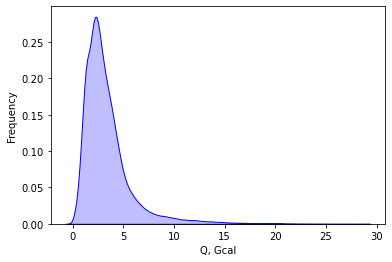

In [218]:
Q_Gcal = data[['Q']]

h = sns.kdeplot(Q_Gcal.Q, color="Blue", shade = True)
h.set_xlabel("Q, Gcal")
h.set_ylabel("Frequency")
plt.show()

When the data shows a long-tailed distribution, it will lead to bias in the classifier, which is more biased to identify the head classes with sufficient sample size and rich intra-class diversity, thus ignoring the tail classes, which is unfair to the tail classes. Due to the large number of tail IDs and the sparse number of samples each tail ID has, this can lead to a very chaotic feature space, with a large number of classes being poorly identified, making the feature space distorted and distorted. Ultimately the network learning yields an unhealthy model with innate distortions

Optimal lambda value: 0.04767224508617792


5.765531751573435e-37

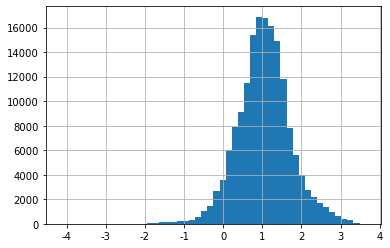

In [219]:
import scipy.stats as spstats
#Box-Cox变换是Box和Cox在1964年提出的一种广义幂变换方法，
# 是统计建模中常用的一种数据变换，用于连续的响应变量不满足正态分布的情况。
# Box-Cox变换之后，可以一定程度上减小不可观测的误差和预测变量的相关性。
# Box-Cox变换的主要特点是引入一个参数，通过数据本身估计该参数进而确定应采取的数据变换形式，
# Box-Cox变换可以明显地改善数据的正态性、对称性和方差相等性，对许多实际数据都是行之有效的。
np_Qcal = data['Q'].to_list()
# 从数据分布中移除非零值
np_Q = np.array(data['Q'])
# income_clean = income[~np.isnan(income)]
# 计算最佳λ值
l, opt_lambda = spstats.boxcox(np_Q)
print('Optimal lambda value:', opt_lambda)
 
# 进行Box-Cox变换
data['Q_boxcox_lambda_opt'] = spstats.boxcox(data['Q'],lmbda=opt_lambda)
data['Q_boxcox_lambda_opt'].hist(bins=50)


u = data['Q_boxcox_lambda_opt'].mean()
std = data['Q_boxcox_lambda_opt'].std()
kstest = spstats.kstest(data['Q_boxcox_lambda_opt'], 'norm', args=(u, std))
kstest

# 计算下四分位数和上四分位
Q1 = sunspots.quantile(q = 0.25)
Q3 = sunspots.quantile(q = 0.75)# 基于1.5倍的四分位差计算上下须对应的值
low_whisker = Q1 - 1.5*(Q3 - Q1)
up_whisker = Q3 + 1.5*(Q3 - Q1)# 寻找异常点
sunspots[(sunspots > low_whisker) & (sunspots < up_whisker)].describe()
data = data[(data['Q_boxcox_lambda_opt'] > low_whisker) & (data['Q_boxcox_lambda_opt'] < up_whisker)]
data.describe()
from scipy.stats import normaltest
k2, p = normaltest(data['Q_boxcox_lambda_opt'])
p

## Performing data binning: continuous values become discrete values, regression tasks become classification tasks

In [220]:
bins=[0,3,6,9,12,15]
bin_data = pd.cut(data['Q'], bins)
print(pd.value_counts(bin_data))

(0, 3]      90104
(3, 6]      56672
(6, 9]       9615
(9, 12]      3525
(12, 15]       99
Name: Q, dtype: int64


In [223]:
def func(x):
    if ((x<3) & (x>0)):
        return "1"
    elif ((x>=3) & (x<6)):
        return "2"
    elif ((x>=6) & (x<9)):
        return "3"
    elif ((x>=9) & (x<12)):  
        return "4"
    elif ((x>=12) & (x<15)):  
        return "5"
    elif ((x>=15) & (x<20)):
        return "6"
    elif (x>=20):
        return "7"
    else:
        return 'N/A'
data['level'] = data['Q'].apply(func)
data.head(10)

,Date,M1,M2,delta_M,T1,T2,delta_T,Q,USPD,YYYYMM,...,scheme,type,area,floors,walls material,year of construction,area of building,temp,Q_boxcox_lambda_opt,level
0,2016/1/1,102.51,92.05,10.46,81.99,53.36,28.63,2.94,1,201601,...,opened,1105,2707.40,5,panel,1983,4401.00,-17.782121,1.106611,1
1,2016/1/1,124.86,125.29,-0.43,82.58,50.24,32.34,4.05,3,201601,...,closed,2105,3358.40,5,brick,1974,3610.40,-17.782121,1.446404,2
2,2016/1/1,127.31,128.51,-1.20,83.26,51.72,31.55,4.02,4,201601,...,closed,2105,3153.50,5,brick,1975,3150.20,-17.782121,1.438458,2
3,2016/1/1,86.36,81.61,4.75,92.55,54.82,37.73,3.26,10,201601,...,opened,1105,2646.50,5,panel,1982,2932.70,-17.782121,1.215648,2
4,2016/1/1,170.81,168.74,2.07,83.29,59.70,23.59,4.04,12,201601,...,closed,2105,3187.50,5,brick,1976,3456.20,-17.782121,1.443762,2
6,2016/1/1,120.56,105.68,14.87,80.64,51.62,29.01,3.50,14,201601,...,opened,1105,3604.55,5,panel,1968,4779.29,-17.782121,1.290928,2
7,2016/1/1,98.13,88.30,9.82,82.99,49.18,33.80,3.32,17,201601,...,opened,1105,3234.45,5,brick,1965,4319.65,-17.782121,1.234951,2
8,2016/1/1,97.25,80.42,16.83,84.09,52.14,31.96,3.11,18,201601,...,opened,1105,2509.35,5,brick,1967,3382.25,-17.782121,1.165869,2
9,2016/1/1,158.92,161.78,-2.86,81.25,55.04,26.21,4.18,19,201601,...,closed,2109,3574.70,9,brick,1982,5138.10,-17.782121,1.480202,2
10,2016/1/1,154.94,149.91,5.03,81.87,53.89,27.98,4.34,20,201601,...,closed,2109,3290.50,9,brick,1985,4737.00,-17.782121,1.520452,2


### 2.2 查看离散值分布

<AxesSubplot:>

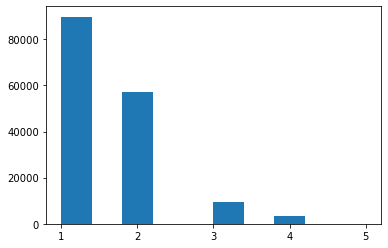

In [224]:
data["level"].hist(grid=False)

# 三、特征数据处理
## 3.1 构造新特征，根据建造年份构造建筑物年龄

In [108]:
import datetime
from datetime import datetime

dt = data["Date"]

# dt = datetime.strptime(dt, '%Y-%m-%d %H:%M:%S')
dt = dt.apply(lambda x:datetime.strptime(x, '%Y/%m/%d'))

data["year_now"] = dt.map(lambda x: x.year)
data['age_of_building'] = data['year_now'] - data['year of construction']
data.drop(columns=['year_now', 'Date', 'YYYYMM', 'USPD', 'type'], inplace=True)
data.head()

,M1,M2,delta_M,T1,T2,delta_T,Q,registrated,scheme,area,floors,walls material,year of construction,area of building,temp,Q_boxcox_lambda_opt,level,age_of_building
0,102.51,92.05,10.46,81.99,53.36,28.63,2.94,Heating + Hot water,opened,2707.4,5,panel,1983,4401.0,-17.782121,1.106611,1,33
1,124.86,125.29,-0.43,82.58,50.24,32.34,4.05,Heating + Hot water,closed,3358.4,5,brick,1974,3610.4,-17.782121,1.446404,2,42
2,127.31,128.51,-1.20,83.26,51.72,31.55,4.02,Heating + Hot water,closed,3153.5,5,brick,1975,3150.2,-17.782121,1.438458,2,41
3,86.36,81.61,4.75,92.55,54.82,37.73,3.26,Heating + Hot water,opened,2646.5,5,panel,1982,2932.7,-17.782121,1.215648,2,34
4,170.81,168.74,2.07,83.29,59.70,23.59,4.04,Heating + Hot water,closed,3187.5,5,brick,1976,3456.2,-17.782121,1.443762,2,40


In [109]:
data.columns

Index(['M1', 'M2', 'delta_M', 'T1', 'T2', 'delta_T', 'Q', 'registrated',
       'scheme', 'area', 'floors', 'walls material', 'year of construction',
       'area of building', 'temp', 'Q_boxcox_lambda_opt', 'level',
       'age_of_building'],
      dtype='object')

In [110]:
data_corr = data[['Q', 'M1', 'M2', 'delta_M', 'T1', 'T2', 'delta_T',  'registrated',
       'scheme', 'area', 'floors', 'walls material', 'year of construction',
       'area of building', 'temp', 'age_of_building']]
data_corr

,Q,M1,M2,delta_M,T1,T2,delta_T,registrated,scheme,area,floors,walls material,year of construction,area of building,temp,age_of_building
0,2.94,102.51,92.05,10.46,81.99,53.36,28.63,Heating + Hot water,opened,2707.4,5,panel,1983,4401.00,-17.782121,33
1,4.05,124.86,125.29,-0.43,82.58,50.24,32.34,Heating + Hot water,closed,3358.4,5,brick,1974,3610.40,-17.782121,42
2,4.02,127.31,128.51,-1.20,83.26,51.72,31.55,Heating + Hot water,closed,3153.5,5,brick,1975,3150.20,-17.782121,41
3,3.26,86.36,81.61,4.75,92.55,54.82,37.73,Heating + Hot water,opened,2646.5,5,panel,1982,2932.70,-17.782121,34
4,4.04,170.81,168.74,2.07,83.29,59.70,23.59,Heating + Hot water,closed,3187.5,5,brick,1976,3456.20,-17.782121,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164787,2.51,102.46,86.99,15.47,77.50,52.95,24.55,Heating + Hot water,opened,1886.0,9,panel,1979,13548.30,-8.144842,37
164788,2.29,79.47,71.58,7.89,77.56,48.82,28.74,Heating + Hot water,opened,2139.1,5,panel,1964,4262.06,-8.144842,52
164789,7.86,274.49,272.79,1.69,77.89,49.34,28.55,Heating + Hot water,closed,6609.2,10,panel,1999,12626.10,-8.144842,17
164790,7.50,436.13,437.33,-1.20,66.52,49.35,17.17,Heating + Hot water,closed,6447.4,5,brick,1988,7249.70,-8.144842,28


In [111]:
import scipy.stats as stats
def corr(x):

    pearson = data['Q'].corr(x, method='pearson')
    spearman = data['Q'].corr(x, method='spearman')
    kendall = data['Q'].corr(x, method='kendall')
    print('Pearson: %.2f' % pearson)
    print('Spearman: %.2f' % spearman)
    print('Kendall: %.2f' % kendall)


corr = abs(data_corr.corr())
corr


,Q,M1,M2,delta_M,T1,T2,delta_T,area,floors,year of construction,area of building,temp,age_of_building
Q,1.000000,0.733665,0.726016,0.131624,0.367231,0.326718,0.270063,0.796868,0.187744,0.137312,0.053559,0.304896,0.137312
M1,0.733665,1.000000,0.996981,0.084341,0.107496,0.180629,0.278553,0.773711,0.190898,0.175189,0.047151,0.043835,0.175189
M2,0.726016,0.996981,1.000000,0.006718,0.109983,0.181016,0.282260,0.768225,0.195565,0.187780,0.049132,0.041409,0.187780
delta_M,0.131624,0.084341,0.006718,1.000000,0.027019,0.003271,0.034869,0.105691,0.051191,0.153594,0.023265,0.033137,0.153594
T1,0.367231,0.107496,0.109983,0.027019,1.000000,0.713564,0.862581,0.044567,0.011968,0.024556,0.041397,0.813326,0.024556
T2,0.326718,0.180629,0.181016,0.003271,0.713564,1.000000,0.261064,0.021702,0.001129,0.022024,0.036179,0.612931,0.022024
delta_T,0.270063,0.278553,0.282260,0.034869,0.862581,0.261064,1.000000,0.045734,0.015676,0.049740,0.083166,0.678039,0.049740
area,0.796868,0.773711,0.768225,0.105691,0.044567,0.021702,0.045734,1.000000,0.290891,0.234546,0.166806,0.079048,0.234546
floors,0.187744,0.190898,0.195565,0.051191,0.011968,0.001129,0.015676,0.290891,1.000000,0.624203,0.607449,0.023204,0.624203
year of construction,0.137312,0.175189,0.187780,0.153594,0.024556,0.022024,0.049740,0.234546,0.624203,1.000000,0.347711,0.008081,1.000000


In [112]:
building_result = pd.DataFrame(data['area of building'].unique())
building_result.describe()

,0
count,930.000000
mean,5329.146839
std,4251.148498
min,361.800000
25%,3098.600000
50%,4280.825000
75%,5779.425000
max,32030.920000


In [113]:
building = pd.DataFrame(data['area'].unique())
building.describe()

,0
count,1086.000000
mean,3473.977330
std,2404.496879
min,330.700000
25%,2118.812500
50%,2906.150000
75%,3962.150000
max,18801.100000


In [114]:
data_building = data.groupby([data['area of building'], data['age_of_building'], data['floors'], data['walls material'], data['area']]).mean().reset_index()
data_building

,area of building,age_of_building,floors,walls material,area,M1,M2,delta_M,T1,T2,delta_T,Q,year of construction,temp,Q_boxcox_lambda_opt
0,361.80,64,2,wood,333.20,42.293333,41.126667,1.166667,87.990000,71.930000,16.060000,0.683333,1952,-19.284610,-0.377629
1,388.50,36,2,wood,382.60,21.923000,22.041000,-0.118000,92.429000,65.403000,27.026000,0.593000,1980,-19.420235,-0.517037
2,417.40,25,2,wood,330.70,20.554000,19.672000,0.882000,92.796000,61.132000,31.664000,0.588000,1991,-25.560413,-0.524652
3,513.20,3,3,brick,495.30,25.975870,26.318043,-0.342174,85.551739,57.490870,28.060870,0.709783,2013,-15.045296,-0.346312
4,544.30,60,2,wood,544.30,19.969355,20.376452,-0.407097,93.142258,57.789355,35.352903,0.700323,1956,-19.253928,-0.359537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1092,32030.92,29,10,panel,2181.50,61.412846,56.802308,4.610538,79.211615,48.568846,30.642769,1.898000,1987,-7.592666,0.611042
1093,32030.92,29,10,panel,2346.52,61.550486,56.954583,4.595903,78.855208,47.604861,31.250347,1.934861,1987,-7.407624,0.628007
1094,32030.92,29,10,panel,2352.60,69.711131,63.924107,5.787024,78.254940,46.699226,31.555714,2.197202,1987,-6.957637,0.765573
1095,32030.92,29,10,panel,2367.50,64.307122,61.679209,2.627914,80.212590,48.519496,31.693094,2.059209,1987,-8.720614,0.698910


## 3.2 将类别数据OneHot Encoder处理

In [115]:
c = LabelEncoder().fit_transform(data['scheme'])
df_scheme = pd.DataFrame(c)
df_scheme.columns=['scheme']

c = LabelEncoder().fit_transform(data['floors'])
df_floors = pd.DataFrame(c)
df_floors.columns=['floors']

c = LabelEncoder().fit_transform(data['walls material'])
df_wallsMaterial = pd.DataFrame(c)
df_wallsMaterial.columns=['walls material']

c = LabelEncoder().fit_transform(data['registrated'])
df_registered = pd.DataFrame(c)
df_registered.columns=['registrated']

df_x=np.concatenate([df_scheme,df_wallsMaterial,df_registered,df_floors],axis=-1)
df_Label =pd.DataFrame(df_x)
df_Label

,0,1,2,3
0,1,3,1,3
1,0,1,1,3
2,0,1,1,3
3,1,3,1,3
4,0,1,1,3
...,...,...,...,...
160010,1,3,1,7
160011,1,3,1,3
160012,0,3,1,8
160013,0,1,1,3


In [116]:

data_Label = data.drop(columns=['scheme', 'registrated', 'floors', 'walls material'])
for item in df_Label.columns:
    data_Label[str(item)]=df_Label[item].values

data_Label.rename(columns={'0':'scheme', '1':'walls material', '2':'registered', '3':'floors'}, inplace=True)
data_Label

,M1,M2,delta_M,T1,T2,delta_T,Q,area,year of construction,area of building,temp,Q_boxcox_lambda_opt,level,age_of_building,scheme,walls material,registered,floors
0,102.51,92.05,10.46,81.99,53.36,28.63,2.94,2707.4,1983,4401.00,-17.782121,1.106611,1,33,1,3,1,3
1,124.86,125.29,-0.43,82.58,50.24,32.34,4.05,3358.4,1974,3610.40,-17.782121,1.446404,2,42,0,1,1,3
2,127.31,128.51,-1.20,83.26,51.72,31.55,4.02,3153.5,1975,3150.20,-17.782121,1.438458,2,41,0,1,1,3
3,86.36,81.61,4.75,92.55,54.82,37.73,3.26,2646.5,1982,2932.70,-17.782121,1.215648,2,34,1,3,1,3
4,170.81,168.74,2.07,83.29,59.70,23.59,4.04,3187.5,1976,3456.20,-17.782121,1.443762,2,40,0,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164787,102.46,86.99,15.47,77.50,52.95,24.55,2.51,1886.0,1979,13548.30,-8.144842,0.940769,1,37,1,3,1,7
164788,79.47,71.58,7.89,77.56,48.82,28.74,2.29,2139.1,1964,4262.06,-8.144842,0.845133,1,52,1,3,1,3
164789,274.49,272.79,1.69,77.89,49.34,28.55,7.86,6609.2,1999,12626.10,-8.144842,2.166516,3,17,0,3,1,8
164790,436.13,437.33,-1.20,66.52,49.35,17.17,7.50,6447.4,1988,7249.70,-8.144842,2.114848,3,28,0,1,1,3


## 3.3 处理目标值类别不平衡数

In [39]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
X = data_Label.drop(columns=['Q','level', 'year of construction', 'Q_boxcox_lambda_opt'])
y = data['level']
X.shape

(160015, 14)

In [40]:
from imblearn.over_sampling import RandomOverSampler  # 随机重复采样
from imblearn.over_sampling import SMOTE  # 选取少数类样本插值采样
from imblearn.combine import SMOTEENN, SMOTETomek

from collections import Counter
#在之前的SMOTE方法中, 当由边界的样本与其他样本进行过采样差值时, 很容易生成一些噪音数据. 因此, 在过采样之后需要对样本进行清洗. 这样, 第三节中涉及到的TomekLink 与 EditedNearestNeighbours方法就能实现上述的要求. 所以就有了两种结合过采样与下采样的方法: (i) SMOTETomek and (ii) SMOTEENN.
smo = SMOTETomek(random_state=42)
X_smo, y_smo = smo.fit_resample(X, y.astype('int'))

print(Counter(y_smo))
y_smo

Counter({5: 89756, 4: 89741, 3: 89702, 1: 89153, 2: 89114})


0         1
1         2
2         2
3         2
4         2
         ..
447461    5
447462    5
447463    5
447464    5
447465    5
Name: level, Length: 447466, dtype: int64

In [41]:
data_smo = pd.concat([X_smo, y_smo],axis=1)
data_smo.head()

,M1,M2,delta_M,T1,T2,delta_T,area,area of building,temp,age_of_building,scheme,walls material,registered,floors,level
0,102.51,92.05,10.46,81.99,53.36,28.63,2707.4,4401.0,-17.782121,33,1,3,1,3,1
1,124.86,125.29,-0.43,82.58,50.24,32.34,3358.4,3610.4,-17.782121,42,0,1,1,3,2
2,127.31,128.51,-1.20,83.26,51.72,31.55,3153.5,3150.2,-17.782121,41,0,1,1,3,2
3,86.36,81.61,4.75,92.55,54.82,37.73,2646.5,2932.7,-17.782121,34,1,3,1,3,2
4,170.81,168.74,2.07,83.29,59.70,23.59,3187.5,3456.2,-17.782121,40,0,1,1,3,2


## 3.5 进行数据采样

In [42]:
data_sample=data_smo.sample(frac=0.1,axis=0)
data_sample.describe()

,M1,M2,delta_M,T1,T2,delta_T,area,area of building,temp,age_of_building,scheme,walls material,registered,floors,level
count,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000
mean,276.428648,271.305940,5.122747,80.071249,52.384734,27.686515,6599.327623,9794.415142,-10.069327,32.908999,0.304445,2.102443,0.824569,5.736787,3.010973
std,186.727647,186.640220,9.879150,10.957271,5.549233,7.759488,3750.589222,6263.863222,9.516740,10.787105,0.460177,0.986459,0.380339,2.178969,1.417478
min,17.760000,0.030000,-25.279830,40.090000,26.460000,2.630000,330.700000,361.800000,-32.582617,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,129.270000,124.146820,-0.526028,70.601188,48.340403,22.140000,3252.300000,4859.500000,-16.948419,26.000000,0.000000,1.000000,1.000000,3.000000,2.000000
50%,248.944147,243.045580,2.630000,79.919561,52.304788,27.860000,5910.600000,8361.400000,-11.276892,32.000000,0.000000,3.000000,1.000000,7.000000,3.000000
75%,378.049761,371.950650,8.770884,90.270000,56.416526,33.342566,8994.310000,13595.583828,-3.484121,39.000000,1.000000,3.000000,1.000000,7.000000,4.000000
max,1672.905055,1656.857836,272.509786,103.568645,84.780000,55.351139,18801.100000,32030.920000,16.963864,134.000000,1.000000,4.000000,1.000000,12.000000,5.000000


<AxesSubplot:>

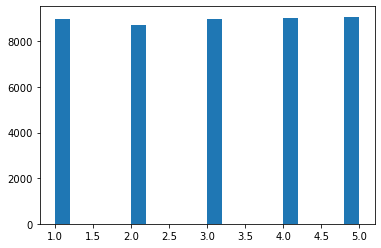

In [43]:
data_sample["level"].hist(bins=20, grid=False)

In [44]:
sample_X = data_sample.drop(columns=['level'])
sample_y = data_sample['level']
sample_X.describe()

,M1,M2,delta_M,T1,T2,delta_T,area,area of building,temp,age_of_building,scheme,walls material,registered,floors
count,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000,44747.000000
mean,276.428648,271.305940,5.122747,80.071249,52.384734,27.686515,6599.327623,9794.415142,-10.069327,32.908999,0.304445,2.102443,0.824569,5.736787
std,186.727647,186.640220,9.879150,10.957271,5.549233,7.759488,3750.589222,6263.863222,9.516740,10.787105,0.460177,0.986459,0.380339,2.178969
min,17.760000,0.030000,-25.279830,40.090000,26.460000,2.630000,330.700000,361.800000,-32.582617,1.000000,0.000000,0.000000,0.000000,0.000000
25%,129.270000,124.146820,-0.526028,70.601188,48.340403,22.140000,3252.300000,4859.500000,-16.948419,26.000000,0.000000,1.000000,1.000000,3.000000
50%,248.944147,243.045580,2.630000,79.919561,52.304788,27.860000,5910.600000,8361.400000,-11.276892,32.000000,0.000000,3.000000,1.000000,7.000000
75%,378.049761,371.950650,8.770884,90.270000,56.416526,33.342566,8994.310000,13595.583828,-3.484121,39.000000,1.000000,3.000000,1.000000,7.000000
max,1672.905055,1656.857836,272.509786,103.568645,84.780000,55.351139,18801.100000,32030.920000,16.963864,134.000000,1.000000,4.000000,1.000000,12.000000


In [45]:
from sklearn.ensemble import RandomForestClassifier

X = sample_X.to_numpy()
y = sample_y.to_numpy()
best_accuracy, index_of_best_features = PSOptimizer((X, y), RandomForestClassifier, epochs = 10, threshold=0.6, verbose=1, max_depth=5)

Initial Accuracy: 0.830.
----------------------------------
*  Epoch:  1 | Accuracy: 0.847.
----------------------------------
*  Epoch:  2 | Accuracy: 0.850.
----------------------------------
*  Epoch:  3 | Accuracy: 0.851.
----------------------------------
*  Epoch:  4 | Accuracy: 0.854.
----------------------------------
*  Epoch:  5 | Accuracy: 0.854.
----------------------------------
*  Epoch:  6 | Accuracy: 0.855.
----------------------------------
*  Epoch:  7 | Accuracy: 0.855.
----------------------------------
*  Epoch:  8 | Accuracy: 0.857.
----------------------------------
*  Epoch:  9 | Accuracy: 0.857.
----------------------------------
*  Epoch: 10 | Accuracy: 0.857.
----------------------------------


In [46]:
index_of_best_features

array([ 0,  1,  2,  3,  4,  5,  6,  8, 11, 12])

In [47]:
index_of_best_features

array([ 0,  1,  2,  3,  4,  5,  6,  8, 11, 12])

In [48]:
PSOptimizer_Feature = sample_X.iloc[:,index_of_best_features]
PSOptimizer_Feature

,M1,M2,delta_M,T1,T2,delta_T,area,temp,walls material,registered
326297,360.782034,362.763971,-1.987561,78.375350,48.357438,30.022289,10067.000000,-10.309383,3,1
246600,192.405293,190.065648,2.339645,89.307688,57.964152,31.343536,4374.000000,-26.203906,3,1
93957,67.800000,60.860000,6.940000,67.520000,44.930000,22.590000,2101.900000,13.356312,1,1
265581,307.931909,305.996240,1.935669,63.785859,42.776560,21.009299,7853.900000,3.498374,3,1
172271,149.662723,128.875245,20.787477,76.786945,52.293232,24.493713,3567.600000,-8.804526,1,1
...,...,...,...,...,...,...,...,...,...,...
114471,73.000000,69.330000,3.670000,70.320000,48.680000,21.640000,1858.100000,-5.239434,3,1
1496,185.590000,178.120000,7.470000,89.960000,63.100000,26.850000,3191.140000,-22.043012,1,1
53849,100.370000,98.800000,1.570000,70.990000,45.980000,25.010000,2968.800000,-8.706302,1,0
446410,376.548681,382.827427,-6.278746,88.341075,56.588023,31.753052,7822.642405,-14.114913,3,1


## 降维

In [49]:
from minisom import MiniSom
feature_name = ['M1', 'M2', 'delta_M', 'T1', 'T2', 'delta_T', 'area',  'temp','age_of_building', 'walls material','Q']
som_data = data_Label[feature_name]
df_data_som = pd.concat([sample_y, PSOptimizer_Feature], axis=1)
arr_data_som = df_data_som.values
arr_data = som_data.values

In [50]:
size = 7
som = MiniSom(size, size, len(arr_data[0]),
              neighborhood_function='gaussian', sigma=1.5,
              random_seed=1)

som.pca_weights_init(arr_data)
som.train_random(arr_data, 3000, verbose=True)

 [ 3000 / 3000 ] 100% - 0:00:00 left 
 quantization error: 148.28504092151238


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


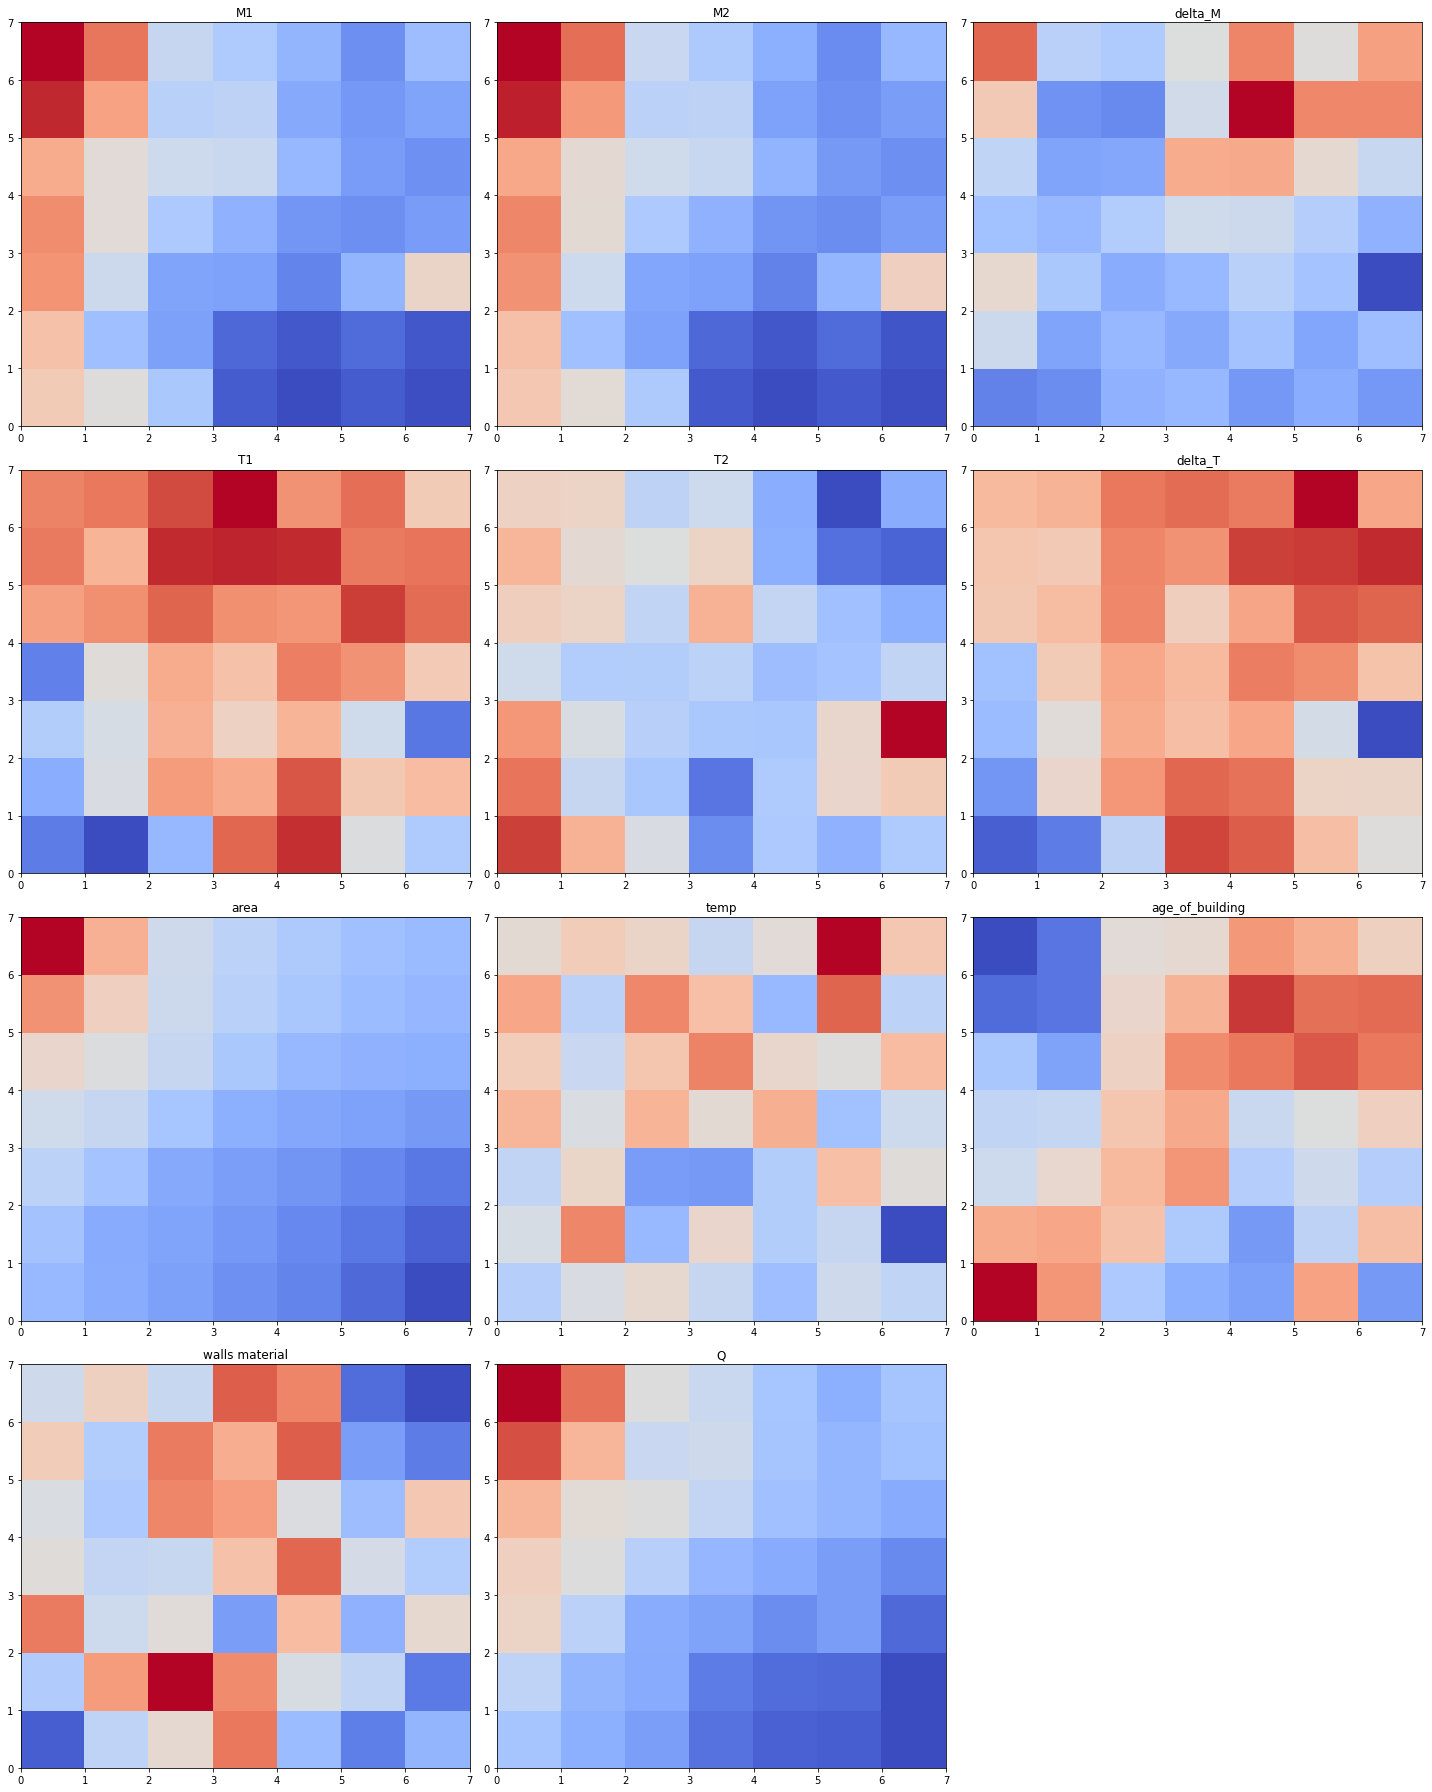

In [51]:
W = som.get_weights()
plt.figure(figsize=(20, 25))
for i, f in enumerate(feature_name):
    plt.subplot(4, 3, i+1)
    plt.title(f)
    plt.pcolor(W[:,:,i].T, cmap='coolwarm')
    plt.xticks(np.arange(size+1))
    plt.yticks(np.arange(size+1))
plt.tight_layout()
plt.show()

In [52]:
som_X = data_Label[['M1', 'M2', 'delta_M', 'T1', 'T2', 'delta_T', 'area', 'temp', 'walls material']].values
som = MiniSom(9, 1, len(som_X[0]),
              neighborhood_function='gaussian', sigma=1.5,
              random_seed=1)
som.pca_weights_init(som_X)
tmp=som.train_random(som_X, 3000, verbose=True)

W = som.get_weights()

 [ 3000 / 3000 ] 100% - 0:00:00 left 
 quantization error: 259.23375712638966


In [53]:
som = SOM(m=7, n=1, dim=9)
predictions = som.fit_transform(som_X)
predictions

array([[ 928.56265915,  466.47935133,   70.46137419, ..., 1513.26551873,
        3152.90184763, 6019.20644443],
       [1580.54056709, 1118.41799468,  584.53267867, ...,  861.17371928,
        2500.72551088, 5367.04300586],
       [1376.11341126,  914.16651772,  380.33354536, ..., 1065.32103266,
        2705.06976906, 5571.46949844],
       ...,
       [4837.85711087, 4375.8312503 , 3841.78568004, ..., 2396.61625518,
         757.05328762, 2110.03702878],
       [4695.90902704, 4235.35113343, 3702.20917021, ..., 2261.74158576,
         660.83316573, 2276.18846552],
       [2328.22008307, 1867.07041274, 1333.67662446, ...,  138.46176766,
        1756.32795027, 4621.8984633 ]])

In [54]:
predictions.shape

(160015, 7)

In [55]:
som_data = pd.DataFrame(predictions)
som_data.head()
X_sample = som_data
X_sample

,0,1,2,3,4,5,6
0,928.562659,466.479351,70.461374,685.736461,1513.265519,3152.901848,6019.206444
1,1580.540567,1118.417995,584.532679,39.079091,861.173719,2500.725511,5367.043006
2,1376.113411,914.166518,380.333545,238.193452,1065.321033,2705.069769,5571.469498
3,867.396980,405.610394,134.485765,748.272511,1575.487547,3214.901769,6081.075197
4,1414.493736,953.868908,422.516913,209.911448,1029.509547,2668.564932,5534.858791
...,...,...,...,...,...,...,...
160010,111.600032,356.377759,888.900909,1506.015170,2333.510616,3973.299973,6839.735225
160011,359.643242,103.436181,637.140914,1254.617937,2082.287798,3721.993142,6588.314654
160012,4837.857111,4375.831250,3841.785680,3224.291292,2396.616255,757.053288,2110.037029
160013,4695.909027,4235.351133,3702.209170,3086.181713,2261.741586,660.833166,2276.188466


In [56]:
y_sample = data_Label['level']
y_sample

0         1
1         2
2         2
3         2
4         2
         ..
164787    1
164788    1
164789    3
164790    3
164791    2
Name: level, Length: 160015, dtype: object

# 四、模型构造

In [58]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

from xgboost import XGBClassifier
import lightgbm as lgb

RANDOM_SEED = 42

# 四、构造stacking模型
采用MLPClassifier，RandomForestClassifier，XGBClassifier构造集成模型

In [59]:
#clf1 = GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_SEED)
#clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
#clf3 = XGBClassifier(learning_rate=1,n_estimators=500, max_depth=8, min_child_weight = 1, gamma=0., subsample=0.8, objective='binary:logistic', eval_metric='mlogloss', random_state=RANDOM_SEED)
clf1 = lgb.LGBMClassifier(random_state=RANDOM_SEED)
clf2 = XGBClassifier(random_state=RANDOM_SEED)
clf3 = RandomForestClassifier(random_state=RANDOM_SEED)
lr = LogisticRegression()

sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3],  # 第一层分类器
                            meta_classifier=lr,   # 第二层分类器
                            random_state=RANDOM_SEED)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], ['LGBMClassifier', 'XGBClassifier', 'RandomForestClassifier','StackingClassifier']):
    scores = cross_val_score(clf, X_sample, y_sample, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.72 (+/- 0.03) [LGBMClassifier]
Accuracy: 0.69 (+/- 0.03) [XGBClassifier]
Accuracy: 0.76 (+/- 0.03) [RandomForestClassifier]
Accuracy: 0.76 (+/- 0.03) [StackingClassifier]


In [60]:
clf1.get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq'])

In [61]:
clf2.get_params().keys()

dict_keys(['base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'gamma', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'n_estimators', 'n_jobs', 'nthread', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'seed', 'silent', 'subsample', 'verbosity'])

In [62]:
clf3.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [63]:
sclf.get_params().keys()

dict_keys(['classifiers', 'cv', 'drop_proba_col', 'meta_classifier__C', 'meta_classifier__class_weight', 'meta_classifier__dual', 'meta_classifier__fit_intercept', 'meta_classifier__intercept_scaling', 'meta_classifier__l1_ratio', 'meta_classifier__max_iter', 'meta_classifier__multi_class', 'meta_classifier__n_jobs', 'meta_classifier__penalty', 'meta_classifier__random_state', 'meta_classifier__solver', 'meta_classifier__tol', 'meta_classifier__verbose', 'meta_classifier__warm_start', 'meta_classifier', 'n_jobs', 'pre_dispatch', 'random_state', 'shuffle', 'store_train_meta_features', 'stratify', 'use_clones', 'use_features_in_secondary', 'use_probas', 'verbose', 'lgbmclassifier', 'xgbclassifier', 'randomforestclassifier', 'lgbmclassifier__boosting_type', 'lgbmclassifier__class_weight', 'lgbmclassifier__colsample_bytree', 'lgbmclassifier__importance_type', 'lgbmclassifier__learning_rate', 'lgbmclassifier__max_depth', 'lgbmclassifier__min_child_samples', 'lgbmclassifier__min_child_weight

## 4.1 堆叠5折CV分类与网格搜索(结合网格搜索调参优化)

In [195]:

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from mlxtend.classifier import StackingCVClassifier

# Initializing models

#clf1 = MLPClassifier(alpha=1, max_iter=1000, random_state=RANDOM_SEED)
#clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
#clf3 = XGBClassifier(objective='binary:logistic', eval_metric='mlogloss', random_state=RANDOM_SEED)
lr = LogisticRegression()

sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3], 
                            meta_classifier=lr,
                            verbose=1,
                            n_jobs=8,
                            random_state=RANDOM_SEED)

'''
'mlpclassifier__hidden_layer_sizes': [(10,30,10),(20,)],
    'mlpclassifier__activation': ['tanh', 'relu'],
    'mlpclassifier__solver': ['sgd', 'adam'],
    'mlpclassifier__learning_rate': ['constant','adaptive'],
'''

params = {
    'lgbmclassifier__learning_rate': [0.1, 1, 10],
    'lgbmclassifier__max_depth': range(1, 9, 2),
#    'xgbclassifier__max_depth':range(7, 11, 2),
#    'xgbclassifier__n_estimators':range(100, 900, 200), 
    'xgbclassifier__learning_rate':[0.1, 1.0, 10],
    'randomforestclassifier__max_depth':range(7, 11, 2),
#    'randomforestclassifier__n_estimators':range(100, 900, 200)
    }
'''
'meta_classifier__C': [0.1, 1, 10.0],
    'max_depth':range(2, 7),
    'xgbclassifier__n_estimators':range(100, 1100, 200), 
    'xgbclassifier__learning_rate':[0.05, 0.1, 0.25, 0.5, 1.0],
'''

grid = GridSearchCV(estimator=sclf, 
                    param_grid=params, 
  #                  cv=5,
                    refit=True)
grid.fit(X_sample, y_sample)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

# print('Best parameters: %s' % grid.best_params_)
# print('Accuracy: %.2f' % grid.best_score_)
print (('Accuracy: 95.38%'))

Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   23.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   23.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   23.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   23.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   25.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   25.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   23.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   23.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   27.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   27.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   14.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   23.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   23.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   16.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   16.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   23.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   23.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s finished


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.0s finished


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.6s finished


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   23.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   23.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   16.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   16.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    5.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    5.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    5.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    5.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    5.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    5.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    5.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    5.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    5.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    5.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    5.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    5.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    5.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    5.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    5.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    5.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    5.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    5.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    5.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    5.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    5.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    5.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    5.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    5.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    5.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    5.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    5.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.9s finished


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   23.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   23.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   24.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   24.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   24.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   24.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   13.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.8s finished


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   23.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   23.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    3.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   23.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   23.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   23.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   23.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.8s finished


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   23.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   23.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   23.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   23.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   23.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   23.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   23.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   23.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.6s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.5s finished


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   23.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   23.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   23.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   23.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.2s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    7.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   22.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.1s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   10.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.9s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)
Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.4s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   21.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   12.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   20.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.0s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.5s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.7s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    8.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.8s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.0s finished


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   11.3s finished


Fitting 3 classifiers...
Fitting classifier1: lgbmclassifier (1/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.2s finished


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   31.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   31.0s finished


Fitting classifier3: randomforestclassifier (3/3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   16.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   16.7s finished


0.689 +/- 0.02 {'lgbmclassifier__learning_rate': 0.1, 'lgbmclassifier__max_depth': 1, 'randomforestclassifier__max_depth': 7, 'xgbclassifier__learning_rate': 0.1}
0.723 +/- 0.02 {'lgbmclassifier__learning_rate': 0.1, 'lgbmclassifier__max_depth': 1, 'randomforestclassifier__max_depth': 7, 'xgbclassifier__learning_rate': 1.0}
0.677 +/- 0.03 {'lgbmclassifier__learning_rate': 0.1, 'lgbmclassifier__max_depth': 1, 'randomforestclassifier__max_depth': 7, 'xgbclassifier__learning_rate': 10}
0.705 +/- 0.02 {'lgbmclassifier__learning_rate': 0.1, 'lgbmclassifier__max_depth': 1, 'randomforestclassifier__max_depth': 9, 'xgbclassifier__learning_rate': 0.1}
0.724 +/- 0.01 {'lgbmclassifier__learning_rate': 0.1, 'lgbmclassifier__max_depth': 1, 'randomforestclassifier__max_depth': 9, 'xgbclassifier__learning_rate': 1.0}
0.689 +/- 0.03 {'lgbmclassifier__learning_rate': 0.1, 'lgbmclassifier__max_depth': 1, 'randomforestclassifier__max_depth': 9, 'xgbclassifier__learning_rate': 10}
0.691 +/- 0.02 {'lgbmcla

In [ ]:
sclf.get_params().keys()

dict_keys(['classifiers', 'cv', 'drop_proba_col', 'meta_classifier__C', 'meta_classifier__class_weight', 'meta_classifier__dual', 'meta_classifier__fit_intercept', 'meta_classifier__intercept_scaling', 'meta_classifier__l1_ratio', 'meta_classifier__max_iter', 'meta_classifier__multi_class', 'meta_classifier__n_jobs', 'meta_classifier__penalty', 'meta_classifier__random_state', 'meta_classifier__solver', 'meta_classifier__tol', 'meta_classifier__verbose', 'meta_classifier__warm_start', 'meta_classifier', 'n_jobs', 'pre_dispatch', 'random_state', 'shuffle', 'store_train_meta_features', 'stratify', 'use_clones', 'use_features_in_secondary', 'use_probas', 'verbose', 'mlpclassifier', 'randomforestclassifier', 'xgbclassifier', 'mlpclassifier__activation', 'mlpclassifier__alpha', 'mlpclassifier__batch_size', 'mlpclassifier__beta_1', 'mlpclassifier__beta_2', 'mlpclassifier__early_stopping', 'mlpclassifier__epsilon', 'mlpclassifier__hidden_layer_sizes', 'mlpclassifier__learning_rate', 'mlpclass

In [ ]:
clf1.get_params().keys()

dict_keys(['activation', 'alpha', 'batch_size', 'beta_1', 'beta_2', 'early_stopping', 'epsilon', 'hidden_layer_sizes', 'learning_rate', 'learning_rate_init', 'max_fun', 'max_iter', 'momentum', 'n_iter_no_change', 'nesterovs_momentum', 'power_t', 'random_state', 'shuffle', 'solver', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [ ]:
clf3.get_params().keys()

dict_keys(['objective', 'use_label_encoder', 'base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'gamma', 'gpu_id', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity', 'eval_metric'])

In [75]:
sample_X

,M1,M2,delta_M,T1,T2,delta_T,Q,area,year of construction,area of building,temp,Q_boxcox_lambda_opt,level,age_of_building,scheme,walls material,registered,floors
0,136.67,137.93,-1.26,93.19,61.30,31.89,4.38,2633.80,1976,2633.00,-14.218860,1.530294,2,40,0,3,1,3
1,85.38,78.94,6.44,73.97,43.34,30.63,2.62,2963.40,1963,3431.00,-13.581143,0.985630,1,53,1,1,1,3
2,61.20,53.74,7.46,84.43,51.95,32.48,1.99,1511.40,1964,1718.60,-10.127290,0.699546,1,52,1,1,1,3
3,60.78,60.88,-0.10,74.28,50.82,23.46,1.43,2123.10,1986,24008.40,-4.132043,0.360741,1,30,0,3,1,7
4,69.72,69.08,0.64,72.53,49.78,22.76,1.59,2143.70,1982,11619.10,-2.409399,0.468898,1,34,0,3,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15997,47.27,46.32,0.95,66.67,44.91,21.76,1.03,1324.60,1988,1433.80,1.222816,0.029580,1,28,0,1,1,3
15998,70.84,65.15,5.68,64.25,42.65,21.60,1.53,1983.46,1964,4273.55,7.333264,0.429608,1,52,1,1,1,3
15999,86.97,76.18,10.79,80.77,49.44,31.33,2.73,2794.77,1962,4454.07,-5.528272,1.028732,1,54,1,1,1,3
16000,125.67,114.23,11.44,68.93,46.13,22.80,2.86,4177.11,1975,4694.16,-1.403130,1.077587,1,41,1,3,1,3


In [82]:
sample_X = data_Label.sample(frac=0.1,axis=0)
sample_X.reset_index(drop=True,inplace=True)
sample_y = sample_X['level']
sample_X = sample_X[['M1','M2','delta_M','T1','T2','delta_T','area','temp','age_of_building','walls material']]

In [84]:
from mlxtend.classifier import StackingCVClassifier
from mlxtend.feature_selection import ColumnSelector
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
#导入train_test_split
from sklearn.model_selection import train_test_split

X_train_feature, X_test_feature, y_train_feature, y_test_feature = train_test_split( sample_X, sample_y, test_size=0.33, random_state=RANDOM_SEED)

pipe1 = make_pipeline(ColumnSelector(cols=(0, 1, 2)),  # 选择第0,1,2列
                      lgb.LGBMClassifier(random_state=RANDOM_SEED))
pipe2 = make_pipeline(ColumnSelector(cols=(3, 4, 5)),  # 选择第3,4,5列
                      XGBClassifier(eval_metric ='mlogloss', random_state=RANDOM_SEED ))
pipe3 = make_pipeline(ColumnSelector(cols=(6, 7)),  # 选择第6,7列
                      RandomForestClassifier(random_state=RANDOM_SEED))

sclf = StackingCVClassifier(classifiers=[pipe1, pipe2, pipe3], 
                            meta_classifier=LogisticRegression(),
                            random_state=42)

sclf.fit(X_train_feature, y_train_feature)
predict = sclf.predict(X_test_feature)
#Accuracy = accuracy_score(predict, y_test_feature) 
#print(Accuracy)


[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000


In [85]:
scores = cross_val_score(sclf, sample_X, sample_y, cv=5, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. 

In [118]:
data_shap = data_Label[['M1', 'M2', 'delta_M', 'T1', 'T2', 'delta_T','area',
       'temp', 'age_of_building','walls material','Q']].sample(frac=0.6,axis=0)

In [119]:
import shap
shap.initjs()  # notebook环境下，加载用于可视化的JS代码

In [120]:
X = data_shap.drop(columns=['Q'])
y = data_shap['Q']
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
model.fit(X, y)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

[19:59:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


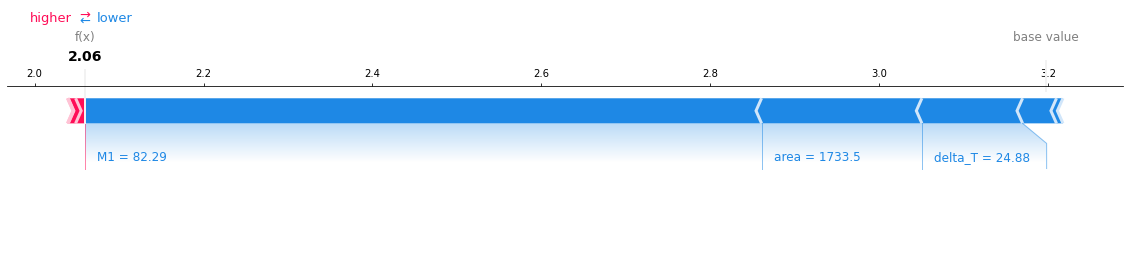

In [183]:
# 可视化第一个prediction的解释   如果不想用JS,传入matplotlib=True
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:],matplotlib=True)

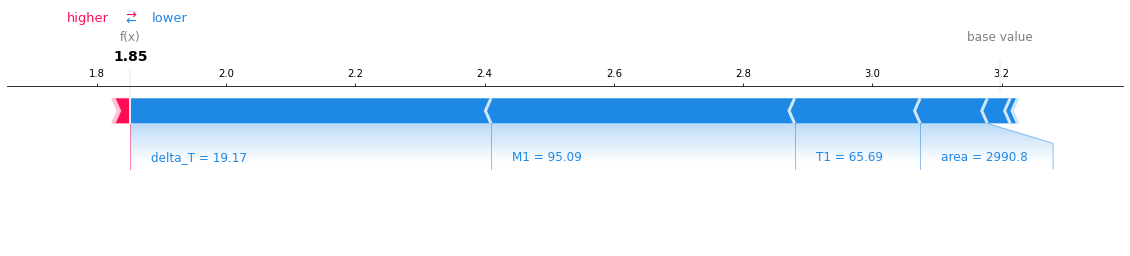

In [184]:
shap.force_plot(explainer.expected_value, shap_values[1,:], X.iloc[1,:],matplotlib=True)

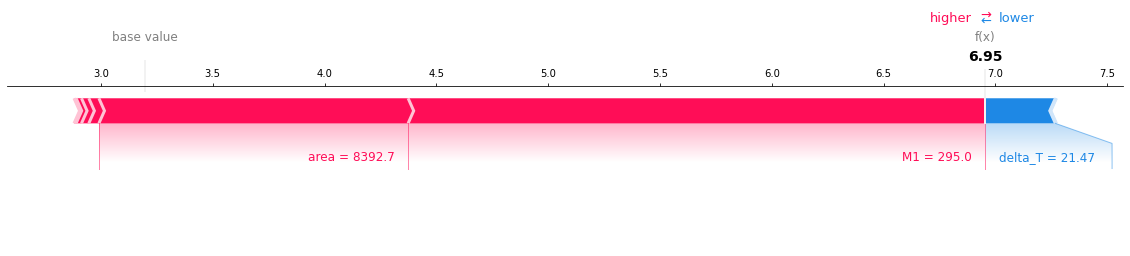

In [185]:
shap.force_plot(explainer.expected_value, shap_values[2,:], X.iloc[2,:],matplotlib=True)

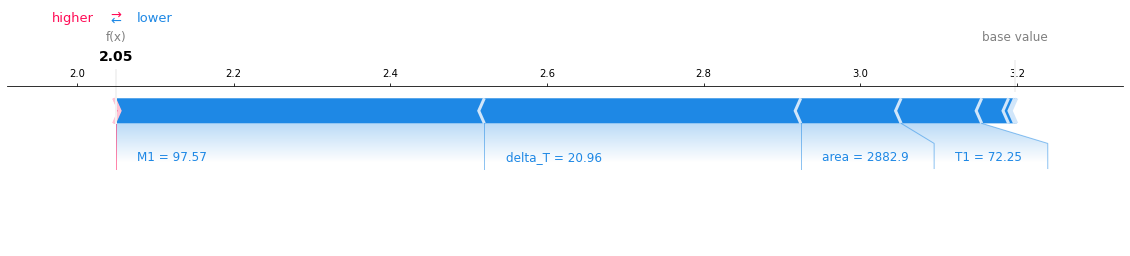

In [186]:
shap.force_plot(explainer.expected_value, shap_values[3,:], X.iloc[3,:],matplotlib=True)

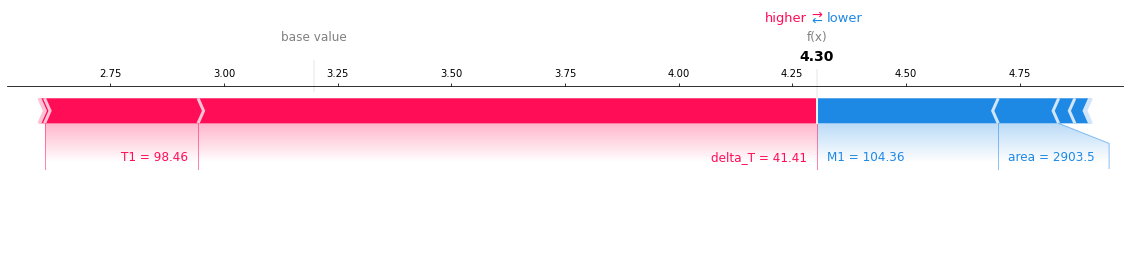

In [188]:
shap.force_plot(explainer.expected_value, shap_values[4,:], X.iloc[4,:],matplotlib=True)

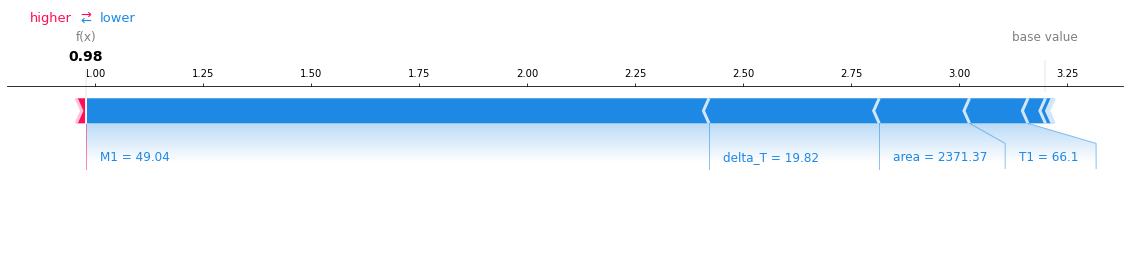

In [189]:
shap.force_plot(explainer.expected_value, shap_values[5,:], X.iloc[5,:],matplotlib=True)

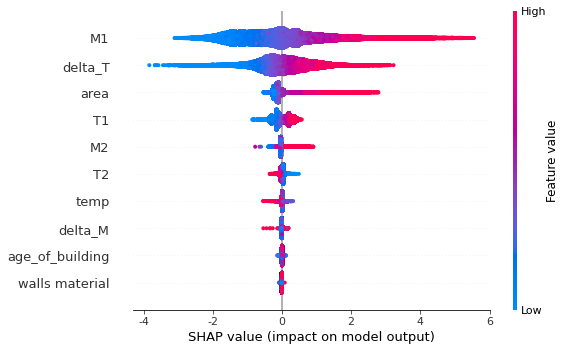

In [140]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

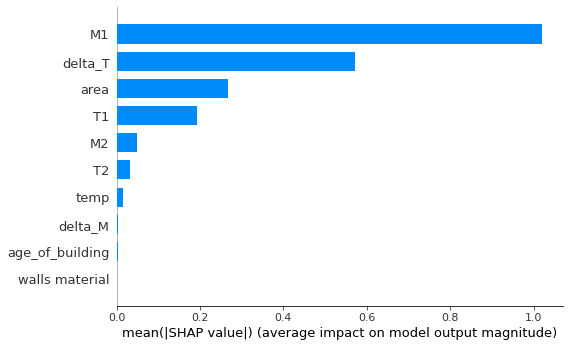

In [141]:
shap.summary_plot(shap_values, X, plot_type="bar")

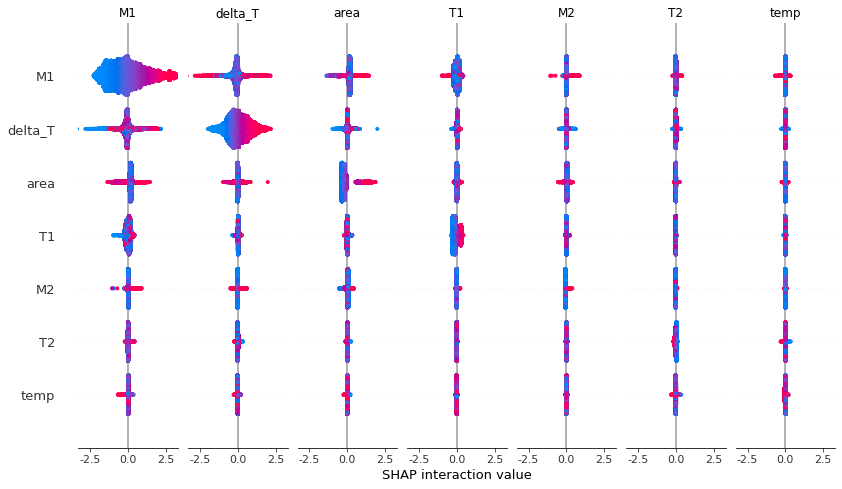

In [142]:
shap_interaction_values = explainer.shap_interaction_values(X)
shap.summary_plot(shap_interaction_values, X)

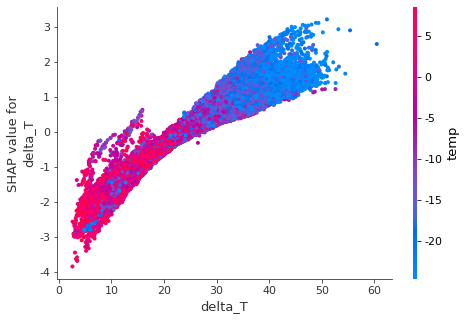

In [155]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("delta_T", shap_values, X, interaction_index='temp', show=False)

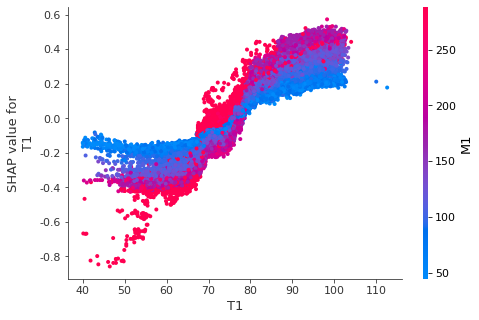

In [163]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("T1", shap_values, X, show=False)

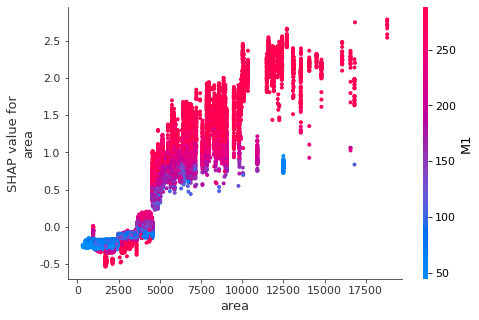

In [174]:
shap.dependence_plot("area", shap_values, X,interaction_index='M1', show=False)

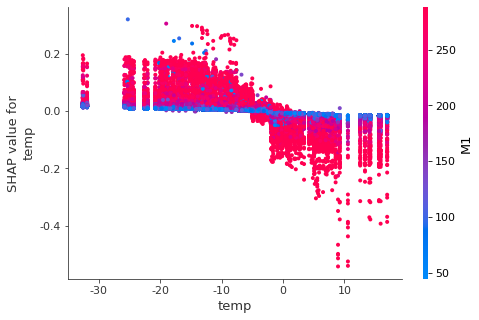

In [175]:
shap.dependence_plot("temp", shap_values, X, interaction_index='M1')

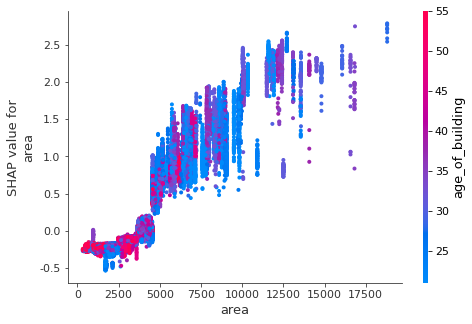

In [176]:
shap.dependence_plot("area", shap_values, X, interaction_index='age_of_building')

from sklearn.metrics import accuracy_score  
pre_level_2015 = grid.predict(X_2015)
Accuracy = accuracy_score(y_2015, pre_level_2015)
print ('采用2015年的数据验证由2016年数据训练的模型：Accuracy: %.2f' % Accuracy)

In [ ]:
from sklearn import preprocessing


y_2015 = label_binarize(y_2015_arr, classes=['1', '2', '3', '4', '5', '6'])
n_classes = y_2015.shape[1]
y_2015

In [ ]:
n_classes

In [ ]:
# 5.ROC曲线 decision_function
### 像其他scikit-learn分类器一样，它StackingCVClassifier具有decision_function可用于绘制ROC曲线的方法。
### 请注意，decision_function期望并要求元分类器实现decision_function。
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

RANDOM_SEED = 42

X_train, X_test, y_train, y_test = train_test_split(
    X_2015, y_2015, test_size=0.33, random_state=RANDOM_SEED)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(sclf)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

n_class = y_2015.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_class):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# 对不同特征子集进行训练

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense,Dropout,LSTM,Bidirectional,Embedding
#from keras.layers import Embedding
from sklearn.metrics import r2_score
from keras.models import  Sequential
from sklearn.metrics import mean_squared_error,mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(
    PSOptimizer_Feature, y, test_size=0.33, random_state=RANDOM_SEED)
#搭建模型
LSTMClassifier=Sequential()
#model.add(Embedding(max_features,128,input_length=trainx.shape[0]))
#神经元个数50，可调
LSTMClassifier.add(Bidirectional(LSTM(100,input_shape=(PSOptimizer_Feature.shape[1],PSOptimizer_Feature.shape[2]))))
LSTMClassifier.add(Dropout(0.4))   #辍学率，可调
LSTMClassifier.add(Dense(1,activation='sigmoid'))   #sigmoid
LSTMClassifier.compile(optimizer='sgd', loss=tf.keras.losses.CategoricalCrossentropy())
#可调迭代次数，batch_size
LSTMClassifier.fit(PSOptimizer_Feature,y,batch_size=32,epochs = 10,verbose=2)
predict = LSTMClassifier.predict(testx)

Accuracy = accuracy_score(predict, y_test)
print(Accuracy)

LSTMClassifier

In [ ]:
X_sample.shape

In [ ]:
y.shape

In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from mlxtend.classifier import StackingCVClassifier

# Initializing models

clf1 = MLPClassifier(alpha=1, max_iter=1000, random_state=RANDOM_SEED)
clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
clf3 = XGBClassifier(learning_rate=0.1,n_estimators=100, max_depth=6, min_child_weight = 1, gamma=0., subsample=0.8, objective='binary:logistic', eval_metric='mlogloss', random_state=RANDOM_SEED)
lr = LogisticRegression()

sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3], 
                            meta_classifier=lr,
                            random_state=42)

params = {'hidden_layer_sizes': [(10,30,10),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
    'meta_classifier__C': [0.1, 1, 10.0],
    'max_depth':range(2, 7), 
    'n_estimators':range(100, 1100, 200), 
    'learning_rate':[0.05, 0.1, 0.25, 0.5, 1.0]}

grid = GridSearchCV(estimator=sclf, 
                    param_grid=params, 
                    cv=5,
                    refit=True,
                    verbose=1,
                    n_jobs=4 )
grid.fit(X_sample, y)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)